# Training Latent Graph Autoencoder

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import torchvision
import torch
from torchvision.transforms import Compose, ToTensor, Resize, Scale
from torch.utils.data.dataloader import DataLoader
from torch.nn.functional import one_hot
from graph_autoencoder import LatentGraphVAE
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from datetime import datetime

In [3]:
device = 'cuda:0'

In [4]:
transforms = Compose([
    ToTensor(),
    Resize((320//2, 480//2)),
    ])
dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
dataloader = DataLoader(dataset=dataset, batch_size=1)

In [5]:
def to_np(tnsr):
    return tnsr.detach().cpu().numpy().transpose((1,2,0))

In [18]:
lgvae = LatentGraphVAE(n_channels=3, w=320//2, h=480//2, device=device).to(device)
optim = torch.optim.Adam(params=lgvae.parameters())

optim.zero_grad()
batch_size = 100
n_epochs = 5
i=0
batch_loss = 0
batch_variance = 0
batch_overlap = 0
batch_l1 = 0
batch_total = 0
checkpoint = 1000
niter = 100000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, niter//batch_size)

tmstp = datetime.strftime(datetime.now(), '%Y%m%d-%H%M')

image,_ = next(iter(dataloader))
# print(image.shape)

for epoch in range(n_epochs):
    i=0
    for image,_ in dataloader:
    # for j in range(niter):
        image = image.squeeze(0).to(device)
        recon = lgvae(image)
        recon_loss = torch.mean((recon - image)**2) 
        loss = recon_loss
        loss.backward()
        batch_loss += float(recon_loss)/batch_size
        
        i+=1
        if i%batch_size==0:
            optim.step()
            optim.zero_grad()
            lr = scheduler.get_last_lr()
            print(f"epoch={epoch:4d} n={i:8d} loss={batch_loss:8.4f} " +
                  f"lr={lr} total={batch_total}",
             flush=True)
            batch_loss = 0
            batch_overlap = 0
            batch_variance = 0
            batch_l1 = 0
            batch_total = 0
            # scheduler.step()
        if i%checkpoint==0:
            torch.save(lgvae.state_dict(), f'models/lgvae_{tmstp}.torch')
            save_image(recon, f'outputs/pooled_graph_ae_{epoch}-{i}_{tmstp}.png')


epoch=   0 n=     100 loss=  0.2082 lr=[0.001] total=0
epoch=   0 n=     200 loss=  0.2035 lr=[0.001] total=0
epoch=   0 n=     300 loss=  0.1888 lr=[0.001] total=0
epoch=   0 n=     400 loss=  0.1305 lr=[0.001] total=0
epoch=   0 n=     500 loss=  0.7435 lr=[0.001] total=0
epoch=   0 n=     600 loss=  0.1363 lr=[0.001] total=0
epoch=   0 n=     700 loss=  0.1818 lr=[0.001] total=0
epoch=   0 n=     800 loss=  0.1913 lr=[0.001] total=0
epoch=   0 n=     900 loss=  0.1892 lr=[0.001] total=0
epoch=   0 n=    1000 loss=  0.1902 lr=[0.001] total=0


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


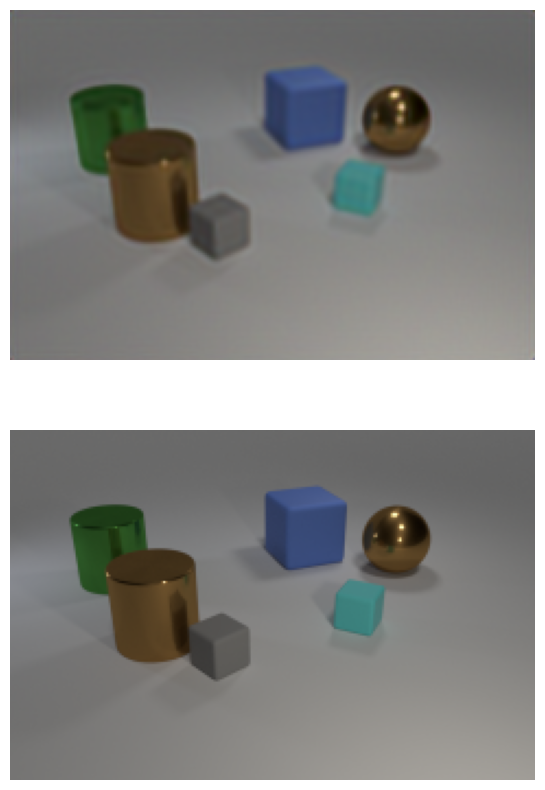

In [17]:
fig, axs = plt.subplots(2, figsize=(40,10))
recon = to_np(lgvae(image))

axs[0].axis('off')
axs[1].axis('off')
axs[0].imshow(recon)
axs[1].imshow(to_np(image))

In [ ]:
nodes[:,2,:4,:4]

tensor([[[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
   

## Validation Set testing

In [ ]:
val_dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
iter_val_loader = iter(val_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


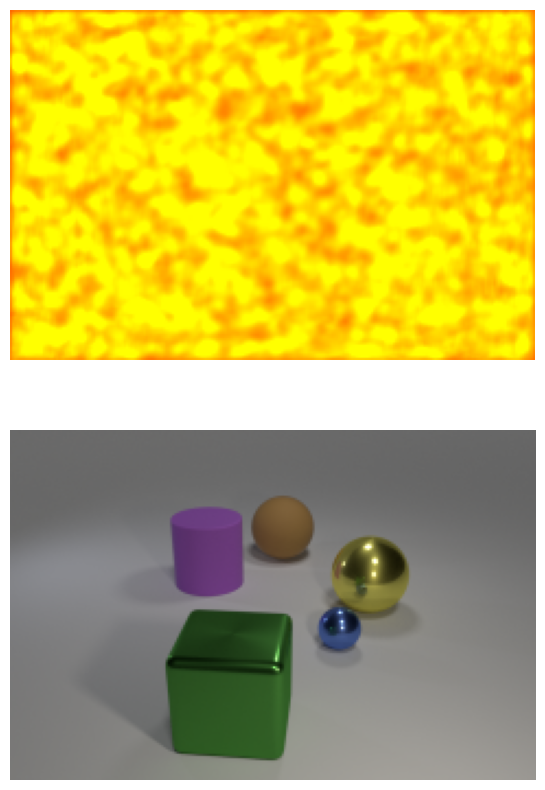

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10,10))

with torch.no_grad():
    val_recons = []
    for i in range(10):
        val_image,_ = next(iter_val_loader)
        val_image = val_image.squeeze(0).to(device)
        val_nodes = lgvae(val_image)
        val_recon = build_image(val_nodes)
        val_nprecon = to_np(val_recon)
        val_recons.append(val_recon)
    # print((val_recons[8] - vala_recons[2]).sum())
    axs[0].axis('off')
    axs[0].imshow(val_nprecon*8)
    axs[1].axis('off')
    axs[1].imshow(to_np(val_image))